In [18]:
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt

In [19]:
# read data
contingent_ema = pd.read_csv('eventcontingent-ema.csv')
puff_marker = pd.read_csv('puff-probability.csv')

contingent_ema_alternative = pd.read_csv('eventcontingent-ema-alternative.csv')
puff_marker_alternative = pd.read_csv('puff-probability-alternative.csv')

contingent_ema_backup = pd.read_csv('eventcontingent-ema-backup.csv')
puff_marker_backup = pd.read_csv('puff-probability-backup.csv')

In [56]:
def contingent_puff(contingent_ema, puff_marker, delta):
    ema_stats = {}
    ema_times = {}
    puff_times = {}
    puff_counts = {}
    puff_probs = {}
    print("Set delta to {} minutes".format(delta))
    for index, row in puff_marker.iterrows():
        user = row['participant_id']
        if user not in puff_times:
            puff_times[user] = {}
            puff_counts[user] = {}
            puff_probs[user] = {}
        try:
            time = datetime.datetime.strptime(row['date'], '%m/%d/%y %H:%M')
        except:
            continue
        date = (time.year, time.month, time.day, int(row['hour']))
        prob_date = (time.year, time.month, time.day, int(row['hour']), int(row['minute']))
        
        if date not in puff_times[user]:
            puff_times[user][date] = set()
        puff_times[user][date].add(int(row['minute']))
        
        if prob_date not in puff_probs[user]:
            puff_probs[user][prob_date] = float(row['event'])
        
    for index, row in contingent_ema.iterrows():
        user = row['participant_id']
        if user not in ema_stats:
            ema_stats[user] = {'total':0, 'completed':0, 'smoked':0, 'HTM':0}
            ema_times[user] = [] 
        ema_stats[user]['total'] += 1
        if row['status'] != "MISSED":
            ema_stats[user]['completed'] += 1

        try:
            time = datetime.datetime.strptime(row['date'], '%m/%d/%y %H:%M')
        except:
            time = datetime.datetime.strptime(row['date'], '%Y-%m-%d %H:%M:%S')

        date = (time.year, time.month, time.day, time.hour, time.minute)
        
        ema_stats[user]['smoked'] += 1
        ema_times[user].append(date)

        # check if HTM detected
        smoked = False
        for i in range(delta):
            if i > time.minute:
                current_hour = time.hour-1
                current_minute = 60-(i-time.minute)
            else:
                current_hour = time.hour
                current_minute = time.minute-i
            puff_time = (time.year, time.month, time.day, current_hour)
            if puff_time not in puff_times[user]:
                continue
            
            if current_minute in puff_times[user][puff_time]:
                if not smoked:
                    ema_stats[user]['HTM'] += 1 # indicator
                    smoked = True
                    
                if puff_time not in puff_counts[user]:
                    puff_counts[user][puff_time] = [0,0]
                puff_counts[user][puff_time][0] += 1 # count
                
                prob_date = (time.year, time.month, time.day, current_hour, current_minute)
                puff_counts[user][puff_time][1] += puff_probs[user][prob_date]
    total_HTM = 0
    total_puff = 0
    total_prob = 0
    count_prob = 0
    print("")
    for user in ema_stats:
        total_puff += ema_stats[user]['smoked']
        total_HTM += ema_stats[user]['HTM']
#         print(user, ema_stats[user])
    print("percentage of contingent events covered by HTM is:{}".format(total_HTM/total_puff))
    
    for user in puff_counts:
        current = puff_counts[user]
        for puff in current:
            total_prob += current[puff][0]
            count_prob += 1
#             print(int(user),puff, current[puff][0])
    print("average number of HTMs detected per contingent event: {}".format(total_prob/count_prob))    
    return ema_stats, puff_counts



def make_graph(puff_counts):
    probs = []
    counts = []
    for user in puff_counts:
        current = puff_counts[user]
        for puff in current:
            counts.append(current[puff][0])
            probs.append(current[puff][1]/current[puff][0])
    plt.figure
    plt.scatter(counts, probs)


Set delta to 60 minutes

percentage of contingent events covered by HTM is:0.8944444444444445
average number of HTMs detected per contingent event: 4.055555555555555


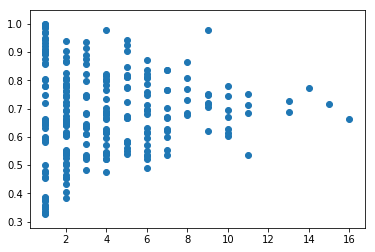

In [57]:
ema_stats, puff_counts = contingent_puff(contingent_ema, puff_marker,60)
make_graph(puff_counts)

Set delta to 30 minutes

percentage of contingent events covered by HTM is:0.8388888888888889
average number of HTMs detected per contingent event: 3.3876404494382024


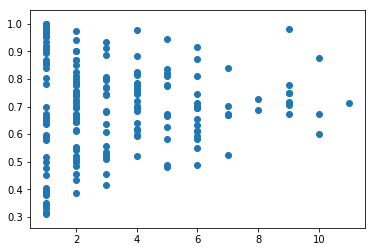

In [58]:
ema_stats, puff_counts = contingent_puff(contingent_ema, puff_marker,30)
make_graph(puff_counts)

Set delta to 15 minutes

percentage of contingent events covered by HTM is:0.75
average number of HTMs detected per contingent event: 2.8785714285714286


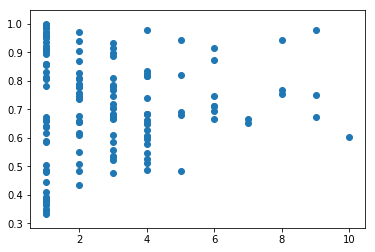

In [59]:
ema_stats, puff_counts = contingent_puff(contingent_ema, puff_marker,15)
make_graph(puff_counts)

Set delta to 5 minutes

percentage of contingent events covered by HTM is:0.5
average number of HTMs detected per contingent event: 1.8021978021978022


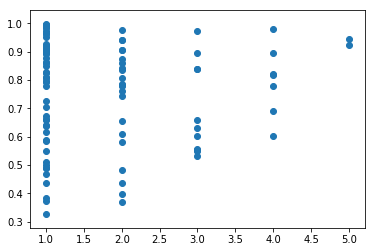

In [60]:
ema_stats, puff_counts = contingent_puff(contingent_ema, puff_marker,5)
make_graph(puff_counts)